In [1]:
import math
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, Input, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split
from pyjarowinkler import distance
import re
from multiprocessing import Pool

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [2]:
out_file_name = 'data/merchants_data_extracted.csv'

In [3]:
#processed_data_out_filename = 'data/raw_cc_processed_data.csv'
processed_data_out_filename = 'data/raw_cc_processed_data_2.csv'

In [4]:
start_index_model_filename = 'data/raw_cc_start_index_model_2.h5'
end_index_model_filename = 'data/raw_cc_end_index_model_2.h5'

### Load data from the database

In [5]:
mysql_query = "select raw_trans_string, merchant_string_td2 \
    from raw_cc \
    where merchant_string_td2 is not null"

In [6]:
mysql_connection = %env MYSQL_CONN_STRING

In [7]:
data = pd.read_sql(mysql_query, mysql_connection)

In [8]:
data.shape

(1911479, 2)

In [9]:
data.head()

raw_trans_string merchant_string_td2
0  EXXONMOBIL    47315353   WAYLAND      MI         Exxon Mobil
1                 MET FOOD STATEN ISLAND NY           Met Foods
2  FOOD4LESS #0313          HAWTHORNE    CA         Food 4 Less
3  FOOD LION #1442          FREDERICK    MD           Food Lion
4     UBER TECHNOLOGIES INC 866-576-1039 CA                Uber

### Process data

In [10]:
data = data.drop_duplicates('raw_trans_string')

#### Normalize raw_trans_string

In [11]:
r1 = re.compile(r'[A-Za-z\'\-]+|\d+|\W+')
r2 = re.compile(r'\s+')
data['raw_trans_string'] = data.apply(lambda x: r2.sub(" "," ".join(r1.findall(x[0]))).strip(), axis=1)

In [12]:
data.head()

raw_trans_string merchant_string_td2
0             EXXONMOBIL 47315353 WAYLAND MI         Exxon Mobil
1                  MET FOOD STATEN ISLAND NY           Met Foods
2            FOOD 4 LESS # 0313 HAWTHORNE CA         Food 4 Less
3              FOOD LION # 1442 FREDERICK MD           Food Lion
4  UBER TECHNOLOGIES INC 866 - 576 - 1039 CA                Uber

In [13]:
def jaro_winkler_distance(str1, str2):
    def jaro_winkler_sim(str1, str2):
        # Tuple with (str_with_lowest_len, str_with_largest_len)
        min_str, max_str = (str2, str1) if len(str1) > len(str2)  else (str1, str2)
        min_str_len = len(min_str)
        max_str_len = len(max_str)
        lookahead = int(max(min_str_len, max_str_len) / 2 - 1)
        m = sum([ min_str[i] == max_str[i] for i in range(min(min_str_len, max_str_len))])
        t = 0
        if m == 0:
            return 0
        for i in range(min(min_str_len, max_str_len)):
            for j in range(1, lookahead):
                if i + j < max_str_len:
                    t += 1 if min_str[i] == max_str[i+j] else 0
                if i > j:
                    t += 1 if min_str[i] == max_str[j-i] else 0
        return ( 1/3 * ( m / min_str_len + m / max_str_len + (m - t) / m))
    
    sim = jaro_winkler_sim(str1, str2)
    p = 0.1
    l = max([ min(len(str1[:i]), len(str2[:i])) if str1[:i] == str2[:i] else 0 for i in range(1, 4) ])
    return 1 - (sim + (l*p*(1 - sim)))

In [14]:
# Retrieve merchant_name as a substring in raw_str
def merchant_name_from_raw_string(merchant_name, raw_str):
    found = raw_str.lower().find(merchant_name.lower())
    if found >= 0:
        return (raw_str[found:found + len(merchant_name)], None)
    else:
        tokens = raw_str.split(' ')
        best_tokens = (None, 0)
        for i in range(len(tokens)):
            for j in range(i + 1, len(tokens) + 1):
                sub_str = " ".join(tokens[i:j])
                sub_str_dist = distance.get_jaro_distance(merchant_name, sub_str)
                if sub_str_dist > best_tokens[1]:
                    best_tokens = (sub_str, sub_str_dist)
        return best_tokens if best_tokens[0] != None else None 

In [15]:
# Time processing time
%time data['merchant_string_in_raw'] = data[:10000].apply( lambda x: merchant_name_from_raw_string(x[1], x[0]), axis=1 )

CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 4.43 s


#### Pool the previous task if necessary

In [16]:
#data_array = list(zip(data.index.values.tolist(),  data[['raw_trans_string', 'merchant_string']].values.tolist()))

In [17]:
#def get_merchant_string_in_raw(x):
#    return (x[0], merchant_name_from_raw_string(x[1][1], x[1][0]))

In [18]:
#p = Pool(8)

In [19]:
#%time merchant_string_in_raw = p.map( get_merchant_string_in_raw, data_array)

In [20]:
#merchant_string_in_raw_df = pd.DataFrame(list(map(lambda x: (x[0], x[1][0], x[1][1]), merchant_string_in_raw)), columns=['Index', 'merchant_string_in_raw', 'distance'])

In [21]:
#merchant_string_in_raw_df.shape

In [22]:
#full_data = data.drop('merchant_string_in_raw', axis=1).join(merchant_string_in_raw_df.set_index('Index'))

In [23]:
#full_data.shape

In [24]:
data['merchant_string_in_raw'] = data.apply( lambda x: merchant_name_from_raw_string(x[1], x[0]), axis=1 )

In [25]:
full_data = data

In [26]:
full_data.head()


raw_trans_string merchant_string_td2  \
0             EXXONMOBIL 47315353 WAYLAND MI         Exxon Mobil   
1                  MET FOOD STATEN ISLAND NY           Met Foods   
2            FOOD 4 LESS # 0313 HAWTHORNE CA         Food 4 Less   
3              FOOD LION # 1442 FREDERICK MD           Food Lion   
4  UBER TECHNOLOGIES INC 866 - 576 - 1039 CA                Uber   

  merchant_string_in_raw  
0     (EXXONMOBIL, 0.97)  
1       (MET FOOD, 0.97)  
2    (FOOD 4 LESS, None)  
3      (FOOD LION, None)  
4           (UBER, None)

In [27]:
full_data[full_data['merchant_string_in_raw'].isnull()].shape[0]

79

In [28]:
full_data = full_data[~full_data['merchant_string_in_raw'].isnull()]

In [29]:
full_data['jw_distance'] = full_data[['merchant_string_in_raw']].apply(lambda x: x[0][1], axis=1)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
full_data['start_index'] = full_data[['raw_trans_string', 'merchant_string_in_raw']].apply(lambda x: x[0].find(x[1][0]), axis=1)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
full_data['end_index'] = full_data[['start_index', 'merchant_string_in_raw']].apply( lambda x: x[0] + len(x[1][0]), axis=1 )

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Save processed data

In [32]:
full_data.to_csv(processed_data_out_filename, sep="|", header=True)

## Load processed data

In [5]:
full_data = pd.read_csv(processed_data_out_filename, sep="|", index_col=0).sample(400000)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
full_data.shape

(400000, 6)

In [7]:
full_data.head()

raw_trans_string  \
588547   ALDI 61038 0624 REYNOLDSBURG OH ~~ 08888 ~~ 54...   
906746   USAA FUNDS TRANSFER CR ~~ 03051 ~~~~ 06194 ~~ ...   
1419873                            BESTBUYCOM 688539012097   
686808   WALGREENS # 7499 LAS VEGAS NV ~~ 08888 ~~ 5109...   
1147449                 FAMILY DOLLAR # 4300 PITTSBURGH PA   

        merchant_string_td2   merchant_string_in_raw  jw_distance  \
588547                 ALDI           ('ALDI', None)          NaN   
906746                 USAA           ('USAA', None)          NaN   
1419873            Best Buy     ('BESTBUYCOM', 0.87)         0.87   
686808            Walgreens      ('WALGREENS', None)          NaN   
1147449       Family Dollar  ('FAMILY DOLLAR', None)          NaN   

         start_index  end_index  
588547             0          4  
906746             0          4  
1419873            0         10  
686808             0          9  
1147449            0         13

In [8]:
full_data[['start_index']].sort_values(['start_index'], ascending=False)[:10]

start_index
1325764        11778
1853658          191
1574724          126
39490            121
981392           119
1618954          119
771236           119
88101            119
159051           118
154029           118

In [9]:
full_data[['end_index']].sort_values(['end_index'], ascending=False)[:10]

end_index
1325764      11781
1853658        195
39490          133
771236         131
88101          131
981392         131
1574724        130
154029         130
159051         130
146673         129

In [10]:
# Remove instances with marker higher than pad_size
full_data = full_data[full_data.end_index < 130]

In [11]:
full_data[full_data.jw_distance < 0.7]

raw_trans_string  \
367828   PACIFIC GAS & EL ONLINE PMT *********** 2 POS ...   
400886   KAISERDUES DES : 8007314661 ID : 0000006001276...   
979808   AAFES FT GORDON GA ~~ 08888 ~~ 510982032920134...   
768617         SW AIR DALLAS 7900118449 ( 214 ) 792 - 4223   
1683562  CHECKCARD 0224 DD / BR # 339297 Q 35 MANALAPAN...   
83462    GOGOAIR . COM 877 - 350 - 00 REF # 31741204 SP...   
1822255  BEVERAGES & MO 10 / 10 # 000880946 PURCHASE BE...   
708530   WM SUPERCENTERWal-Mart SuROCKWALL TX ~~ 08888 ...   
62584                       WM SUPERCENTER # 157 SEARCY AR   
1591575  WM SUPERCENTERWal-Mart SuDERBY KS ~~ 08888 ~~ ...   
1637841  AAFES FT POLK S FT POLK LA ~~ 08888 ~~ 5438050...   
2763                            QT 730 07007305 ATLANTA GA   
577613   AAFES SCHOFIELD BARHI ~~ 08888 ~~ 546528003527...   
884034   AAFES FT JACKSN COLUMBIA SC ~~ 08888 ~~ 546528...   
692303                POLO FACTORY STRE # 62 GROVE CITY PA   
386286   CHECKCARD 1011 AMC ST CHARLES TC 9 # 27 WALDOR...   
1072091  AAFES FORT POLK LA ~~ 08888 ~~ 510982013876630...   
1908521  AMEX CAFE-WFC NEWYORK 0026266124 ( 973 ) 526 -...   
137803              MTA MVM * R 610 -ATLANTQPS NEW YORK NY   
754113   QT 420 0 PHOENIX AZ ~~ 08888 ~~ 54380580544254...   
1303038  VZWRLSS * BILL PA FOLSOM CA ~~ 08888 ~~ 546528...   
360567   QT 749 0 MARIETTA GA ~~ 08888 ~~ 5438050711209...   
11404    AA INFLIGHT MC FACETTULSA 058773972 800 - 901 ...   
1444168  QT 436 0 GLENDALE AZ ~~ 08888 ~~ 5438058171394...   
1126811  GOGOAIR . COM 877 - 350 - 003 81919965 TPR INT...   
308870   CHECKCARD 0901 FRYS-MKTPLACE # 641 PHOENIX AZ ...   
443378   AAFES APO ~~ 08888 ~~ 5109820612127910 ~~ 1719...   
1835445  TJX Rewards MC DES : TJX EPAY ID : 1031447909 ...   
1398989  HOMEGOODS # 0568 HUNTSVILLE AL 35806 USA - FAM...   
473563                      AAFES LANGLEY S LANGLEY AFB VA   
...                                                    ...   
840929   AAFES ROBINS AFB GA ~~ 08888 ~~ 54652800472123...   
1139047  WM SUPERCENTERWal-Mart SuSPRINGFIELD MO ~~ 088...   
1780746  VZWRLSS * PRPAY AUTOPAY - 24692164295000269375391   
1359569  AAFES NBFF COFF APO AE ~~ 08888 ~~ 54652800252...   
598275   AAFES APO ~~ 08888 ~~ 5465280023038131 ~~ 9688...   
24692                       CONTAINERSTORETUCSON TUCSON AZ   
1110572                         PAYPAL * HSN 4029357733 FL   
360003   QT 729 0 ATLANTA GA ~~ 08888 ~~ 54380507112094...   
336912   Belk CreditCard DES : Belk EPAY ID : 667268618...   
350642   AAFES 03 / 19 # 000999071 PURCHASE AAFES FORT ...   
575313   AAFES ABERDEEN PROVMD ~~ 08888 ~~ 546528002349...   
645731   AAFES APO ~~ 08888 ~~ 5465280047632422 ~~ 7974...   
1551627  AAFESUNIT 3370 APO ~~ 08888 ~~ 546528001826428...   
144669                MTA MVM * BROADWAY & QPS NEW YORK NY   
623527                     WM SUPERCENTER # 5936 VIENNA VA   
1254959  WM SUPERCENTERWal-Mart SuKILLEEN TX ~~ 08888 ~...   
926073             MTA MVM * N 539 A- 7 AV QPS NEW YORK NY   
580145   AAFES SAM CONV FT SAM HOUSTOTX ~~ 08888 ~~ 543...   
331103   AAFESUNIT 82501 APO ~~ 08888 ~~ 54652800146611...   
679573                 NTTA AUTOCHARGE 972 - 818 - 6882 TX   
122235                     WM SUPERCENTER # 4600 GRETNA NE   
844078   QT 679 0 ST LOUIS MO ~~ 08888 ~~ 5109820607747...   
1484063  WM SUPERCENTER FORT WORTH TX ~~ 08888 ~~ 51098...   
1818893                         HERBERGERS # 0331 MINOT ND   
518291   AAFES WHITEMAN WHITEMAN AFB MO ~~ 08888 ~~ 546...   
434973                          AAFES FORT SILL FT SILL OK   
1593899                      AAFES KADENA BXFC CQPS APO AP   
280181   NJT ABERDN-MAT 01 / 23 # 000686545 PURCHASE NJ...   
1012554  AAFESBLDG 4110 MOSEBY S COLUMBIA SC ~~ 08888 ~...   
765027                   AA INFLIGHT VISA FACET 3 TULSA OK   

                           merchant_string_td2  \
367828                                    PG&E   
400886                                   Sears   
979808     Army and Air Force Exchange Service 

In [12]:
#full_data_filtered = full_data[full_data['distance'] > 0.7]

In [13]:
# Limit text string to pad size

In [14]:
pad_size = 130 # Padding up to 200 PAD Symbols to the text

In [15]:
full_data['raw_trans_string'] = full_data[['raw_trans_string']].apply(lambda x: x[0][0:pad_size], axis=1)

In [16]:
full_data.shape

(399991, 6)

In [17]:
full_data = full_data.reset_index()

In [18]:
full_data['merchant_string_in_raw'].loc[0]

"('ALDI', None)"

In [21]:
for _ in range(100):
    i = np.random.randint(full_data.shape[0])
    extracted_merchant_name = full_data["raw_trans_string"].loc[i][full_data["start_index"][i]:full_data["end_index"][i]]
    orig_merchant_name = full_data['merchant_string_in_raw'].loc[i]
    # For text 
    # assert(extracted_merchant_name.lower() == orig_merchant_name.lower())
    # For tuple
    assert(orig_merchant_name.lower().find(extracted_merchant_name.lower()) > 0)

In [104]:
# Create vocabulary with UNKNOWNS AND PAD Symbols

In [19]:
#DEFAULT_SYMBOLS = u'''abcdefghijklmnopqrstuvwxyz0123456789+'"`’~@*$#.) (!-®&_/\=:;,%?|+-[]{}\x92^'''

In [20]:
DEFAULT_SYMBOLS = u'''abcdefghijklmnopqrstuvwxyz0123456789+'"`’~@*$#.) (!-®&_/\=:;,%?|+-'''

In [21]:
UNKNOWN = 'UNKNOWN'
PAD = 'PAD'
vocab = [UNKNOWN, PAD] + [s for s in DEFAULT_SYMBOLS]

In [22]:
#chars = set([ c for text in full_data['raw_trans_string'].values for c in text ])

In [23]:
char2index = dict((c, i) for i, c in enumerate(vocab)) # Unnecessary variables but easier
index2char = dict((i, c) for i, c in enumerate(vocab))

#### Create training/testing

In [24]:
full_data['encoded_text'] = [ [char2index[char] if char in vocab else char2index[PAD] for char in text] for text in full_data['raw_trans_string'].str.lower().values ]

In [25]:
def pad_vector(vector, pad_size, padding):
    vector[len(vector):pad_size] = np.repeat(padding, pad_size - len(vector))
    return vector

In [26]:
full_data['encoded_text_padded'] = full_data[['encoded_text']].apply( lambda x: pad_vector(x[0], pad_size, char2index[PAD] ), axis=1)

In [33]:
assert(len(full_data['encoded_text_padded'].loc[0]) == pad_size) # Encoded text has same number of characters as original string plus the marquers

In [20]:
#### One hot encoding text

In [27]:
X = np.zeros((full_data['encoded_text_padded'].shape[0], pad_size, len(vocab)), dtype='int8')

In [28]:
for i, vector in enumerate(full_data['encoded_text_padded'].values):
    for j, char in enumerate(vector):
        X[i, j, char] = 1

In [29]:
def one_hot_encode_df(data, vector_column, pad_size, vocab_len):
    X = np.zeros((data[vector_column].shape[0], pad_size, vocab_len))
    for i, vector in enumerate(data[vector_column].values):
        for j, char in enumerate(vector):
            X[i, j, char] = 1
    return X

In [30]:
### Create Targets

In [31]:
Y_begin = to_categorical(full_data['start_index'].values, pad_size)
Y_end = to_categorical(full_data['end_index'].values, pad_size)

In [32]:
#### Create class weights

In [33]:
def create_class_weight(labels_dict, mu=0.15):
    total = sum(labels_dict.values())
    class_weight = dict()

    for key, value in labels_dict.items():
        score = math.log(mu * total / value)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [34]:
start_class_freqs = full_data.groupby('start_index')['merchant_string_td2'].agg(['count'])['count']

In [35]:
begin_class_weights = create_class_weight(start_class_freqs.to_dict())

In [36]:
end_class_freqs = full_data.groupby('end_index')['merchant_string_td2'].agg(['count'])['count']

In [37]:
end_class_weights = create_class_weight(end_class_freqs.to_dict())

In [38]:
### Build NN

In [39]:
START_INDEX_BATCH = 512
START_INDEX_EPOCHS = 8
END_INDEX_BATCH = 512
END_INDEX_EPOCHS = 8

In [40]:
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(input_shape[0], input_shape=input_shape, activation="relu"))
    model.add(Flatten())
    model.add(Dense(int(input_shape[0])))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [41]:
def build_model_2(input_shape):
    model = Sequential()
    model.add(Dense(input_shape[0] * input_shape[1], input_shape=input_shape, activation="relu"))
    model.add(Flatten())
    model.add(Dense(int(input_shape[0])))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [42]:
def build_dyn_model(input_shape, layers):
    model = Sequential()
    for i,layer in enumerate(layers):
        if i == 0:
            model.add(Dense(layer['hidden_nb'], input_shape=input_shape, activation=layer['activation']))
        elif i == len(layers) - 1:
            model.add(Flatten())
            model.add(Dense(layer['hidden_nb']))
        else:
            #model.add(Flatten())
            model.add(Dense(layer['hidden_nb'], activation=layer['activation']))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [71]:
### Train and test simple

In [52]:
model = build_model((pad_size, len(vocab)))

In [53]:
#Y = np.array([hot_encode_index_pos(index, pad_size) for index in data[['begin_marker']].values ])

In [54]:
model_output = model.fit(X, Y_begin, batch_size=BATCH, epochs=EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
200000/200000 [==============================] - 42s 211us/step - loss: 0.9748 - acc: 0.9418
Epoch 2/4
200000/200000 [==============================] - 36s 178us/step - loss: 0.8296 - acc: 0.9461
Epoch 3/4
200000/200000 [==============================] - 36s 178us/step - loss: 0.8236 - acc: 0.9466
Epoch 4/4
200000/200000 [==============================] - 36s 178us/step - loss: 0.8262 - acc: 0.9465


In [48]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3_input (InputLayer)   (None, 200, 95)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 200, 200)          19200     
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               8000200   
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
Total params: 8,019,400
Trainable params: 8,019,400
Non-trainable params: 0
_________________________________________________________________


In [42]:
layers = [ { 'hidden_nb': 1024, 'activation': 'relu'} , { 'hidden_nb': 512, 'activation': 'relu'},  { 'hidden_nb': 100, 'activation': 'softmax'}]
dyn_model = build_dyn_model((pad_size, len(vocab)), layers)

In [83]:
dyn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5_input (InputLayer)   (None, 200, 81)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 200, 512)          41984     
_________________________________________________________________
dense_6 (Dense)              (None, 200, 512)          262656    
_________________________________________________________________
dense_7 (Dense)              (None, 200, 512)          262656    
_________________________________________________________________
flatten_3 (Flatten)          (None, 102400)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10240100  
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
Total para

In [84]:
Y_begin.shape

(13331, 100)

In [124]:
dyn_model_output = dyn_model.fit(X, Y_begin, batch_size=BATCH, epochs=EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
13331/13331 [==============================] - 17s 1ms/step - loss: 4.7781 - acc: 0.8738
Epoch 2/4
13331/13331 [==============================] - 17s 1ms/step - loss: 4.7844 - acc: 0.8757
Epoch 3/4
13331/13331 [==============================] - 14s 1ms/step - loss: 4.7844 - acc: 0.8757
Epoch 4/4
13331/13331 [==============================] - 14s 1ms/step - loss: 4.7844 - acc: 0.8757


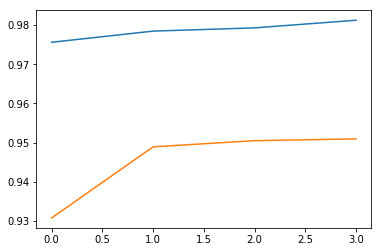

In [106]:
pyplot.plot(model_output.history['acc'])
pyplot.plot(dyn_model_output.history['acc'])

In [71]:
pyplot.show()

In [72]:
model_output.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200, 200)          16400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               4000100   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
Total params: 4,016,500
Trainable params: 4,016,500
Non-trainable params: 0
_________________________________________________________________


In [76]:
dyn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10_input (InputLayer)  (None, 200, 81)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 200, 512)          41984     
_________________________________________________________________
dense_11 (Dense)             (None, 200, 512)          262656    
_________________________________________________________________
dense_12 (Dense)             (None, 200, 512)          262656    
_________________________________________________________________
dense_13 (Dense)             (None, 200, 100)          51300     
Total params: 618,596
Trainable params: 618,596
Non-trainable params: 0
_________________________________________________________________


In [85]:
#### Cross validation for begin marker

In [43]:
kfold = KFold(n_splits=5)

In [44]:
layers = [ { 'hidden_nb': 512, 'activation': 'relu'} , { 'hidden_nb': 512, 'activation': 'relu'}, { 'hidden_nb': 512, 'activation': 'relu'}, { 'hidden_nb': 130, 'activation': 'relu'}]

In [45]:
def accuracy_model(y_true, y_predicted):
    nb_predicted = sum([ y_true[i, np.argmax(y_predicted[i])] for i in range(len(y_predicted)) ])
    return nb_predicted / len(y_predicted)

In [46]:
def accuracy_model_dirty(y_true, y_predicted):
    nb_predicted = sum([ 1 if np.argmax(y_true[i]) <= np.argmax(y_predicted[i]) else 0 for i in range(len(y_predicted)) ])
    return nb_predicted / len(y_predicted)    

In [86]:
for train, test in kfold.split(X):
    model = build_dyn_model((pad_size, len(vocab)), layers)
    model.fit(X[train], Y_begin[train], START_INDEX_BATCH, START_INDEX_EPOCHS, class_weight=begin_class_weights)
    print("Model accuracy %f" % accuracy_model(Y_begin[test], model.predict(X[test])))

NameError: name 'EPOCHS' is not defined

In [49]:
### Cross validation for end marker

In [47]:
for train, test in kfold.split(X):
    model = build_dyn_model((pad_size, len(vocab)), layers)
    model.fit(X[train], Y_end[train], END_INDEX_BATCH, END_INDEX_EPOCHS, class_weight=end_class_weights)
    print("Model accuracy %f" % accuracy_model(Y_end[test], model.predict(X[test])))
    print("Model accuracy dirty %f" % accuracy_model_dirty(Y_end[test], model.predict(X[test])))

Epoch 1/8
319992/319992 [==============================] - 115s 359us/step - loss: 0.7768 - acc: 0.9148
Epoch 2/8
319992/319992 [==============================] - 110s 344us/step - loss: 0.3089 - acc: 0.9653
Epoch 3/8
319992/319992 [==============================] - 112s 349us/step - loss: 0.2438 - acc: 0.9717
Epoch 4/8
319992/319992 [==============================] - 112s 350us/step - loss: 0.2065 - acc: 0.9750
Epoch 5/8
319992/319992 [==============================] - 112s 351us/step - loss: 0.1883 - acc: 0.9767
Epoch 6/8
319992/319992 [==============================] - 113s 354us/step - loss: 0.1746 - acc: 0.9784
Epoch 7/8
319992/319992 [==============================] - 114s 357us/step - loss: 0.1643 - acc: 0.9793
Epoch 8/8
319992/319992 [==============================] - 115s 359us/step - loss: 0.1558 - acc: 0.9802
Model accuracy 0.966625
Model accuracy dirty 0.984787
Epoch 1/8
319993/319993 [==============================] - 116s 364us/step - loss: 0.7820 - acc: 0.9139
Epoch 2/8


KeyboardInterrupt: 

In [ ]:
### Extract merchant_string

In [36]:
def extract_merchant_string_with_model(model_for_start, model_for_end, text_vector):
    X = np.zeros((text_vector.shape[0], pad_size, len(vocab)))
    for i, vector in enumerate(text_vector):
        for j, char in enumerate(vector):
            X[i, j, char] = 1
    return list(zip( \
        [ np.argmax(pred) for pred in model_for_start.predict(X) ], \
        [ np.argmax(pred) for pred in model_for_end.predict(X) ] \
    ))

In [42]:
# Build model for predicting start index

In [43]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y_begin, train_size=0.8)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
x_train = X
y_train = Y_begin

In [49]:
model_s = build_model((pad_size, len(vocab)))
model_s.fit(x_train, y_train, START_INDEX_BATCH, START_INDEX_EPOCHS, class_weight=begin_class_weights)

Epoch 1/8
399991/399991 [==============================] - 22s 55us/step - loss: 0.6084 - acc: 0.9552
Epoch 2/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.2358 - acc: 0.9752
Epoch 3/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1798 - acc: 0.9790
Epoch 4/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1513 - acc: 0.9806
Epoch 5/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1339 - acc: 0.9825
Epoch 6/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1218 - acc: 0.9831
Epoch 7/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1119 - acc: 0.9842
Epoch 8/8
399991/399991 [==============================] - 22s 54us/step - loss: 0.1054 - acc: 0.9846


In [50]:
model_s.save(start_index_model_filename)

In [51]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y_end, train_size=0.8)

In [52]:
x_train = X
y_train = Y_end

In [53]:
model_e = build_model((pad_size, len(vocab)))
model_e.fit(x_train, y_train, END_INDEX_BATCH, END_INDEX_EPOCHS, class_weight=end_class_weights)

Epoch 1/8
399991/399991 [==============================] - 19s 47us/step - loss: 0.9914 - acc: 0.8837
Epoch 2/8
399991/399991 [==============================] - 19s 46us/step - loss: 0.3207 - acc: 0.9615
Epoch 3/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.2371 - acc: 0.9707
Epoch 4/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.1965 - acc: 0.9750
Epoch 5/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.1730 - acc: 0.9776
Epoch 6/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.1547 - acc: 0.9798
Epoch 7/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.1426 - acc: 0.9812
Epoch 8/8
399991/399991 [==============================] - 18s 46us/step - loss: 0.1324 - acc: 0.9824


In [54]:
model_e.save(end_index_model_filename)

In [47]:
def df_extract_string(row):
    indexes = extract_merchant_string_with_model(model_s, model_e, np.array([row[0]]))
    return row[1][indexes[0][0]: indexes[0][1]]

In [49]:
full_data['extracted_merchant_name'] = full_data[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

In [53]:
full_data[['merchant_string_td2', 'raw_trans_string', 'extracted_merchant_name']].to_csv(out_file_name, sep="|")

In [56]:
full_data[['merchant_string_td2', 'raw_trans_string', 'extracted_merchant_name']].head(1000)

merchant_string_td2  \
0                             Hotels.com   
1                                 Target   
2                               Key Food   
3                                 iTunes   
4                                  Shell   
5                                 Sunoco   
6                            Whole Foods   
7                                DirecTV   
8                                   USAA   
9                                   USAA   
10                           Dollar Tree   
11                                Paypal   
12                                  USAA   
13                              Chipotle   
14                              Best Buy   
15                                  Uber   
16                                  USAA   
17                          Trader Joe's   
18                             Walgreens   
19                            Amazon.com   
20                                Target   
21                             Cheddar's   
22                Avis Rent a Car System   
23                                  USAA   
24                            Amazon.com   
25                            McDonald's   
26                              Citibank   
27                           Giant Eagle   
28                   Sally Beauty Supply   
29                  Dollar General Store   
..                                   ...   
970                              Chevron   
971                         CVS Pharmacy   
972                                H-E-B   
973                           Fred Meyer   
974                             Circle K   
975                           Winn-Dixie   
976                               Ralphs   
977                           Amazon.com   
978                               Costco   
979                                FedEx   
980                                 USAA   
981                           Home Depot   
982                                 Hulu   
983                          TGI Fridays   
984                          Taco Cabana   
985                    Papa John's Pizza   
986                          Wells Fargo   
987  Army and Air Force Exchange Service   
988                          Exxon Mobil   
989                           McDonald's   
990                       Dunkin' Donuts   
991                                 USAA   
992                                 ALDI   
993                           Amazon.com   
994                                 USAA   
995                                 AT&T   
996                           Amazon.com   
997                      Delta Air Lines   
998                             7-Eleven   
999                              Wendy's   

                                      raw_trans_string extracted_merchant_name  
0                      HOTELS.COM 800-246-8357 WA05/16              HOTELS.COM  
1    TARGET T0 TARGET T0695 FRANKLIN TN~~08888~~546...                  TARGET  
2    KEY FOODS 089 09/18 000523479 PURCHASE KEY FOO...                KEY FOOD  
3    CHECKCARD 1004 APL ITUNES.COM/BILL 866-712-775...                  ITUNES  
4                  SHELL OIL 57446032203 CLOVERDALE CA                   SHELL  
5                      SUNOCO 0333986801 QPS NEWARK DE                  SUNOCO  
6    WHOLEFDS 7250 W LAKE LAS VEGAS NV~~08888~~5109...                WHOLEFDS  
7    DTV DIRECTV SER 800-347-3288 CA~~08888~~546528...                 DIRECTV  
8    USAA FUNDS TRANSFER CR~~03045~~~~89650~~0~~~~0303                    USAA  
9    USAA FUNDS TRANSFER CR~~03045~~~~34542~~0~~~~0303                    USAA  
10   DOLLAR TREE 0 AMARILLO TX~~08888~~510982060108...             DOLLAR TREE  
11   PAYPAL DES:ECHECK ID:4QFJ295DA55XQ INDN:ASHLEY...                  PAYPAL  
12   USAA.COM PAYMNT LOAN 2654~~08888~~~~31767~~0~~...                    USAA  
13   CHECKCARD 0122 CHIPOTLE 1874 CHARLOTTE NC 2443...                CHIPOTLE  
14   CHECKCARD 0702 BESTBUY GSP MT00015784 800-4335...                 BESTBU

In [93]:
#### Extracting for leave out data only

In [94]:
train_data, test_data = train_test_split(data, train_size=0.8)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [95]:
train_data_ohe_x = one_hot_encode_df(train_data, 'encoded_text_padded', pad_size, len(vocab))

In [96]:
train_data_ohe_y_start = to_categorical(train_data['begin_marker'].values, int(pad_size / 2))
train_data_ohe_y_end = to_categorical(train_data['end_marker'].values, int(pad_size / 2))

In [97]:
model_s = build_model((pad_size, len(vocab)))
model_s.fit(train_data_ohe_x, train_data_ohe_y_start, BATCH, EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
10664/10664 [==============================] - 10s 967us/step - loss: 1.1584 - acc: 0.9321
Epoch 2/4
10664/10664 [==============================] - 4s 361us/step - loss: 0.6899 - acc: 0.9515
Epoch 3/4
10664/10664 [==============================] - 4s 352us/step - loss: 0.5116 - acc: 0.9586
Epoch 4/4
10664/10664 [==============================] - 4s 341us/step - loss: 0.3699 - acc: 0.9657


In [98]:
model_e = build_model((pad_size, len(vocab)))
model_e.fit(train_data_ohe_x, train_data_ohe_y_end, BATCH, EPOCHS, class_weight=end_class_weights)

Epoch 1/4
10664/10664 [==============================] - 4s 329us/step - loss: 1.6845 - acc: 0.7730
Epoch 2/4
10664/10664 [==============================] - 3s 315us/step - loss: 0.4735 - acc: 0.9231
Epoch 3/4
10664/10664 [==============================] - 3s 315us/step - loss: 0.2618 - acc: 0.9535
Epoch 4/4
10664/10664 [==============================] - 3s 313us/step - loss: 0.1603 - acc: 0.9737


In [99]:
test_data['extracted_merchant_name'] = test_data[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
test_data[['merchant_string', 'raw_trans_string', 'extracted_merchant_name', 'clean_trans_string']].to_csv(out_file_name, sep="|")

In [101]:
### Extracting for the dataframe without the merchant name in the text

In [1]:
df_without_merchant_in_string['extracted_merchant_name'] = df_without_merchant_in_string[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

NameError: name 'df_without_merchant_in_string' is not defined

In [102]:
out_file_name = 'data/merchants_data_extracted_without_merchant_name.csv'

In [103]:
df_without_merchant_in_string[['merchant_string', 'raw_trans_string', 'extracted_merchant_name', 'clean_trans_string']].to_csv(out_file_name, sep="|")